# Fetch Data



### Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

### Load Packages

In [2]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

INGESTION_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, INGESTION_PATH)

from src import fetch
from src import config


### Full Pull of Data
Takes about 48 minutes

In [ ]:
# await fetch.fetch_all_service_requests(save = True)

await fetch.fetch_all_service_requests(save = True,
    columns=config.DOHDMH_COLUMNS,
    additional_filter=config.AGENCY_FILTER
)

Fetching 2010-01 ...
Fetching 2010-02 ...
Fetching 2010-03 ...
Fetching 2010-04 ...
Fetching 2010-05 ...
Fetching 2010-06 ...
Fetching 2010-07 ...
Fetching 2010-08 ...
Fetching 2010-09 ...
Fetching 2010-10 ...
Fetching 2010-11 ...
Fetching 2010-12 ...
Fetching 2011-01 ...
Fetching 2011-02 ...
Fetching 2011-03 ...
Fetching 2011-04 ...
Fetching 2011-05 ...
Fetching 2011-06 ...
Fetching 2011-07 ...
Fetching 2011-08 ...


### Incremental Pull of Data

In [ ]:
# await fetch.fetch_current_month_service_requests(save = True)

await fetch.fetch_current_month_service_requests(save = True,
    columns=config.DOHDMH_COLUMNS,
    additional_filter=config.AGENCY_FILTER
)

Fetching current month: 2025-10
Fetching 2025-10 ...
Saved s3://hbc-technical-assessment-gk/landing/DOHMH\year=2025/month=10/part-0000.parquet (443 rows, 23 columns)
Current month data updated successfully!


### ACS Census Data

In [5]:
df_pop = fetch.fetch_acs_census_population_data(start_year=2010, end_year=2025, save=False)

  - County 005...
    Error downloading county 005 for year 2010: Unexpected response (URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B01003_001E&for=block+group:*&in=state:36+county:005): error: unknown/unsupported geography hierarchy 
  - County 047...
    Error downloading county 047 for year 2010: Unexpected response (URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B01003_001E&for=block+group:*&in=state:36+county:047): error: unknown/unsupported geography hierarchy 
  - County 061...
    Error downloading county 061 for year 2010: Unexpected response (URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B01003_001E&for=block+group:*&in=state:36+county:061): error: unknown/unsupported geography hierarchy 
  - County 081...
    Error downloading county 081 for year 2010: Unexpected response (URL: https://api.census.gov/data/2010/acs/acs5?get=NAME,B01003_001E&for=block+group:*&in=state:36+county:081): error: unknown/unsupported geography hierarchy 
  - County 085..

### Historical Weather Data

In [6]:
df_weather = fetch.fetch_noaa_weather_data(start_year=2010, end_year=2025, save=False)

Loaded 201001, rows: 155
Loaded 201002, rows: 155
Loaded 201003, rows: 155
Loaded 201004, rows: 155
Loaded 201005, rows: 155
Loaded 201006, rows: 155
Loaded 201007, rows: 155
Loaded 201008, rows: 155
Loaded 201009, rows: 155
Loaded 201010, rows: 155
Loaded 201011, rows: 155
Loaded 201012, rows: 155
Loaded 201101, rows: 155
Loaded 201102, rows: 155
Loaded 201103, rows: 155
Loaded 201104, rows: 155
Loaded 201105, rows: 155
Loaded 201106, rows: 155
Loaded 201107, rows: 155
Loaded 201108, rows: 155
Loaded 201109, rows: 155
Loaded 201110, rows: 155
Loaded 201111, rows: 155
Loaded 201112, rows: 155
Loaded 201201, rows: 155
Loaded 201202, rows: 155
Loaded 201203, rows: 155
Loaded 201204, rows: 155
Loaded 201205, rows: 155
Loaded 201206, rows: 155
Loaded 201207, rows: 155
Loaded 201208, rows: 155
Loaded 201209, rows: 155
Loaded 201210, rows: 155
Loaded 201211, rows: 155
Loaded 201212, rows: 155
Loaded 201301, rows: 155
Loaded 201302, rows: 155
Loaded 201303, rows: 155
Loaded 201304, rows: 155


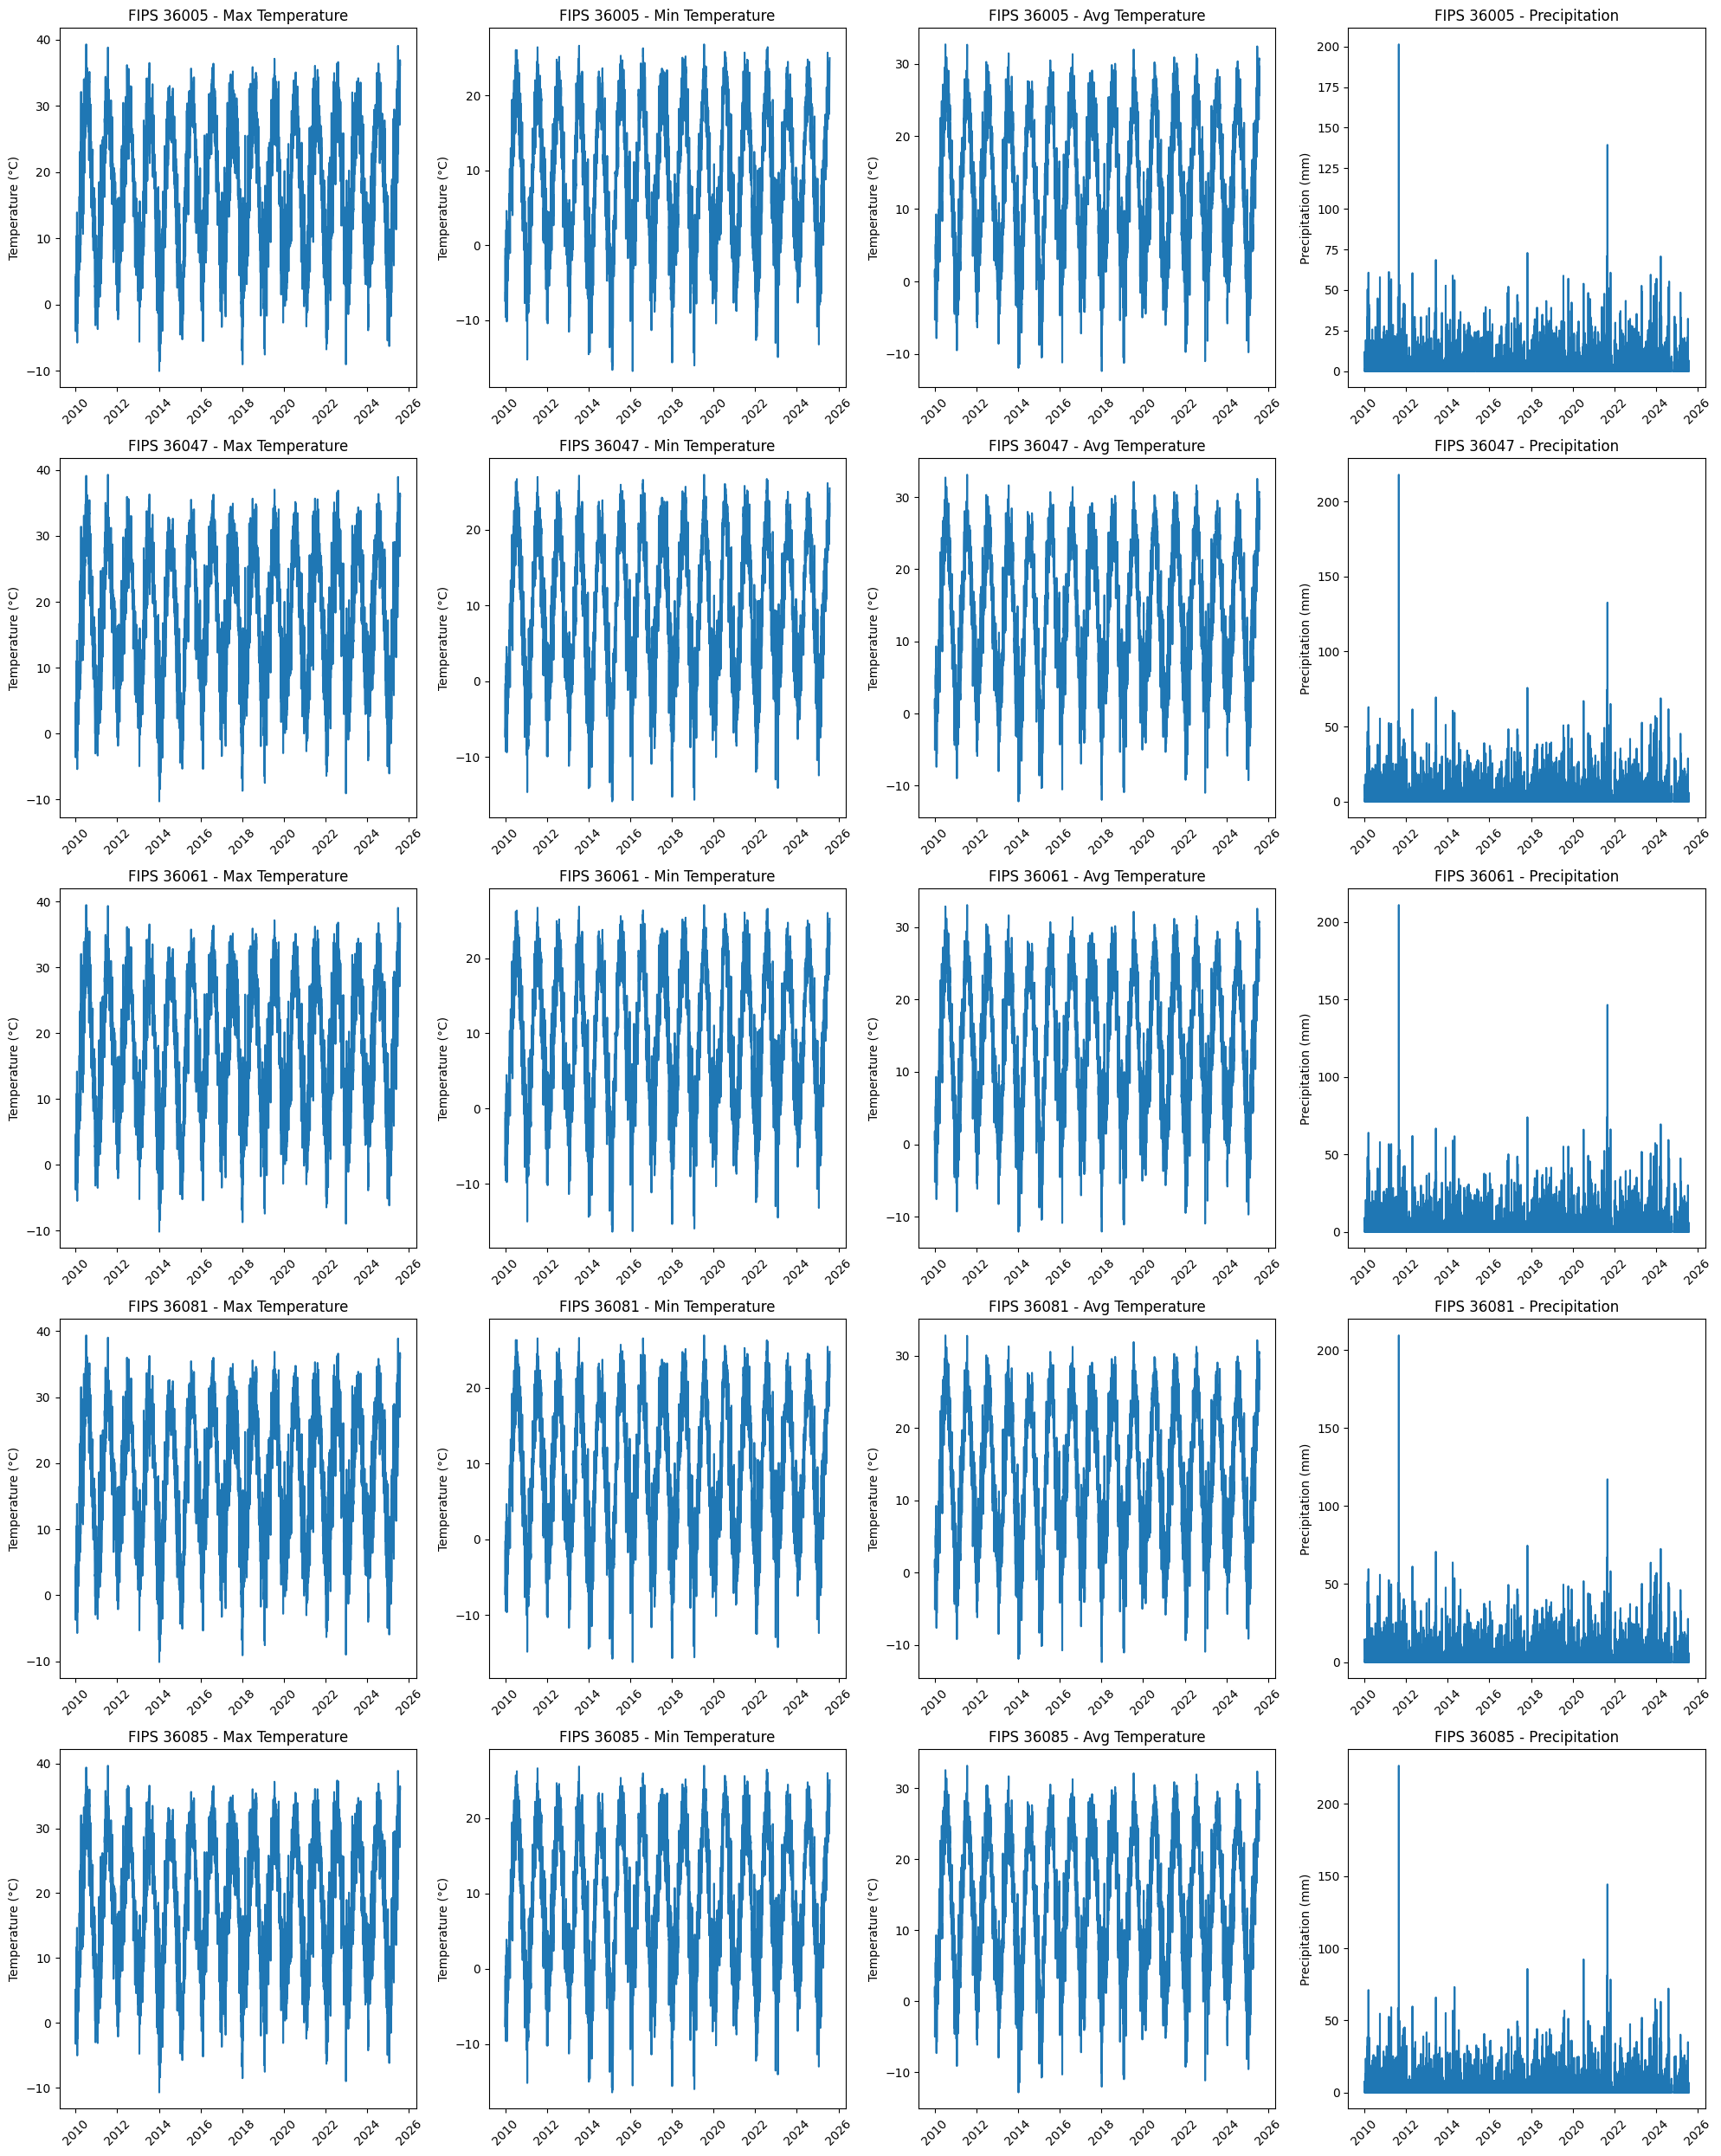

In [7]:
df_weather['tmax'] = df_weather['tmax'].astype(float)
df_weather['tmin'] = df_weather['tmin'].astype(float)
df_weather['tavg'] = df_weather['tavg'].astype(float)
df_weather['prcp'] = df_weather['prcp'].astype(float)

unique_fips = df_weather['fips'].unique()

fig, axes = plt.subplots(len(unique_fips), 4, figsize=(20, 5*len(unique_fips)))

for i, fips in enumerate(unique_fips):
    fips_data = df_weather[df_weather['fips'] == fips].sort_values('date')
    
    axes[i, 0].plot(fips_data['date'], fips_data['tmax'])
    axes[i, 0].set_title(f'FIPS {fips} - Max Temperature')
    axes[i, 0].set_ylabel('Temperature (°C)')
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    axes[i, 1].plot(fips_data['date'], fips_data['tmin'])
    axes[i, 1].set_title(f'FIPS {fips} - Min Temperature')
    axes[i, 1].set_ylabel('Temperature (°C)')
    axes[i, 1].tick_params(axis='x', rotation=45)
    
    axes[i, 2].plot(fips_data['date'], fips_data['tavg'])
    axes[i, 2].set_title(f'FIPS {fips} - Avg Temperature')
    axes[i, 2].set_ylabel('Temperature (°C)')
    axes[i, 2].tick_params(axis='x', rotation=45)

    axes[i, 3].plot(fips_data['date'], fips_data['prcp'])
    axes[i, 3].set_title(f'FIPS {fips} - Precipitation')
    axes[i, 3].set_ylabel('Precipitation (mm)')
    axes[i, 3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
